In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [67]:
pip install xgboost


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Data Load

In [68]:
raw_data = pd.read_csv("/Users/jl/uci-secom.csv", delimiter=',')

# 결측치 검사 및 분포

In [69]:
raw_data.isna().sum()

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

In [70]:
import plotly.express as px
fig = px.histogram(data_frame= raw_data.isna().sum() , nbins=raw_data.shape[1])
fig.show()

# NA 값이 700개 이상인 열 제거

In [71]:
raw_data.drop(columns = raw_data.loc[:,  raw_data.isna().sum() > 700].columns, inplace =True)

## labeling
### Pass: -1 / Fail: 1 시각화

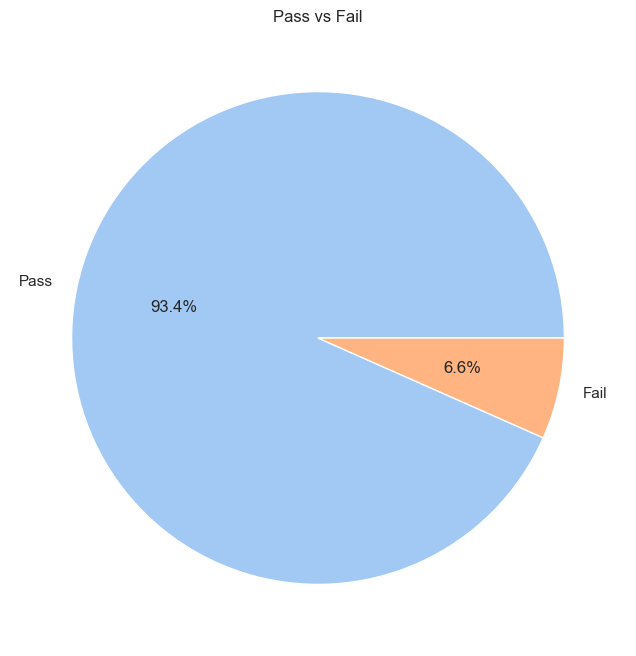

In [72]:
value_counts = raw_data.value_counts("Pass/Fail")
value_counts.index = ['Pass', 'Fail']
plt.figure(figsize=(8,8))
sns.set(style="whitegrid")
plt.pie(value_counts, labels =value_counts.index,  autopct='%1.1f%%', colors = sns.color_palette("pastel"))
plt.title('Pass vs Fail')
plt.show()

In [73]:
passData = raw_data[raw_data["Pass/Fail"].apply(lambda x: int(x)<0)].set_index('Time')
passData.head(3)

,0,1,2,3,4,5,6,7,8,9,...,577,582,583,584,585,586,587,588,589,Pass/Fail
Time,,,,,,,,,,,,,,,,,,,,,
2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1


In [74]:
failData = raw_data[raw_data["Pass/Fail"].apply(lambda x: int(x)>0)].set_index('Time')
failData.head(3)

,0,1,2,3,4,5,6,7,8,9,...,577,582,583,584,585,586,587,588,589,Pass/Fail
Time,,,,,,,,,,,,,,,,,,,,,
2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
2008-07-19 21:57:00,2994.05,2548.21,2195.1222,1046.1468,1.3204,100.0,103.3400,0.1223,1.5144,-0.0190,...,14.5507,0.4925,0.0158,0.0041,3.2115,0.0355,0.0205,0.0071,57.8122,1
2008-07-19 22:52:00,2928.84,2479.40,2196.2111,1605.7578,0.9959,100.0,97.9156,0.1257,1.4690,0.0170,...,12.8058,0.4987,0.0427,0.0092,8.5646,0.0370,0.0279,0.0081,75.5077,1


In [75]:
raw_data  = raw_data.drop('Time', axis = 1)

# 최빈값, 평균값, 중앙값 구하기

In [76]:
class DataMode:
    def __init__(self, data, method):
        self.data = data
        self.method = method


    def calCorr(self):
        if self.method == "Mode":
            return self.data.fillna(self.data.mode().iloc[0])
        elif self.method == "Mean":
            return self.data.fillna(self.data.mean(numeric_only = True))
        elif self.method == "Median":
            return self.data.fillna(self.data.median(numeric_only = True))
        else:
            return -1

In [77]:
def getCorr(raw_data):
    mode = ["Mode", "Mean", "Median"]
    list_data = []
    for i in mode:
        x = DataMode(raw_data, i).calCorr()
        y = x.corrwith(x["Pass/Fail"])
        y = pd.DataFrame(y).drop("Pass/Fail", axis = 0)
        y.columns = ['corr_value']
        y = y.apply(lambda x: abs(x))
        list_data.append(y)
    return list_data

In [78]:
li  = getCorr(raw_data)

In [79]:
# for x in li:
#     x= x.to_numpy()
#     maximum = 2
#     index = -1
#     diff_max = []
#     for i in range(1, x.size):
#         diff = x[i] - x[i-1]
#         tmp = diff/x[i-1]
#         if tmp < -0.05:
#             diff_max.append((i, x[i]))
#     print(diff_max)
#     break

In [80]:
raw_data.corr()

,0,1,2,3,4,5,6,7,8,9,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,1.000000,-0.145071,0.004775,-0.007655,-0.011047,NaN,0.002281,0.031510,-0.052731,0.009052,...,0.008603,0.000225,0.023469,0.019921,0.023605,0.018472,-0.025909,-0.028196,0.004177,-0.025144
1,-0.145071,1.000000,0.005802,-0.007603,-0.001641,NaN,-0.025702,-0.012084,0.031321,0.024015,...,-0.010149,0.043690,0.002905,-0.001264,0.002273,-0.009417,0.017290,0.010134,0.044834,-0.002615
2,0.004775,0.005802,1.000000,0.298935,0.095891,NaN,-0.136225,-0.273970,0.023609,0.016291,...,-0.028713,-0.006061,0.015711,0.018237,0.015765,-0.025548,-0.029479,-0.030943,-0.033226,-0.000957
3,-0.007655,-0.007603,0.298935,1.000000,-0.058483,NaN,-0.685835,0.138290,-0.103656,0.068998,...,0.016443,0.009045,0.025461,0.024754,0.026043,0.034779,-0.039309,-0.033780,-0.081157,-0.024631
4,-0.011047,-0.001641,0.095891,-0.058483,1.000000,NaN,-0.074368,-0.916410,-0.026035,0.054619,...,-0.004072,0.045361,-0.001301,-0.001598,-0.001617,-0.044016,-0.031145,-0.026204,0.051428,-0.013760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,0.018472,-0.009417,-0.025548,0.034779,-0.044016,NaN,-0.041296,0.058171,0.010436,0.033759,...,-0.002684,-0.016726,0.002257,0.001606,0.002744,1.000000,0.167913,0.164238,-0.486559,0.004157
587,-0.025909,0.017290,-0.029479,-0.039309,-0.031145,NaN,0.034184,-0.021472,0.022853,0.059341,...,-0.009405,-0.024481,-0.002650,-0.002498,-0.002931,0.167913,1.000000,0.974276,0.390813,0.035392
588,-0.028196,0.010134,-0.030943,-0.033780,-0.026204,NaN,0.032359,-0.020962,0.026261,0.060803,...,-0.015596,-0.020712,-0.002261,-0.001957,-0.002531,0.164238,0.974276,1.000000,0.389211,0.031168
589,0.004177,0.044834,-0.033226,-0.081157,0.051428,NaN,0.044227,-0.107875,-0.022776,0.004882,...,-0.024766,0.041494,-0.003008,-0.003295,-0.003801,-0.486559,0.390813,0.389211,1.000000,-0.002654


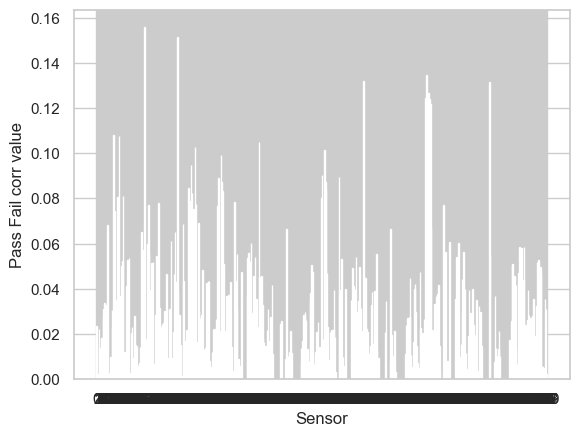

In [81]:
plt.bar(li[0].index, li[0]['corr_value'], color ='skyblue')

plt.xlabel('Sensor')
plt.ylabel('Pass Fail corr value')
plt.show()

In [82]:
a =li[0][li[0].values>0.09]
a.columns

Index(['corr_value'], dtype='object')

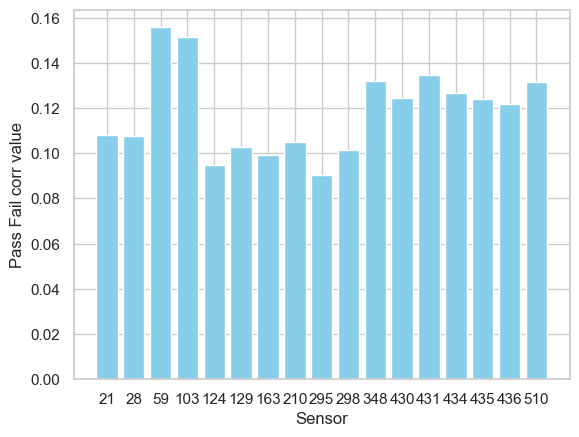

In [83]:
plt.bar(a.index, a['corr_value'], color ='skyblue')
plt.xlabel('Sensor')
plt.ylabel('Pass Fail corr value')
plt.show()

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [85]:
x = raw_data.drop('Pass/Fail', axis = 1)
y = raw_data['Pass/Fail']
x.shape

(1567, 558)

In [86]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [87]:
x_train = pd.DataFrame(StandardScaler().fit_transform(x_train)).reset_index(drop=True)
x_train.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,557
439,0.903335,-0.496687,0.541383,-0.637051,-0.064793,0.0,-0.175503,-0.112768,-1.605869,0.245330,...,-0.209987,0.238920,0.481394,-0.051818,0.026875,-0.055302,0.771296,1.771090,1.203831,0.020778
1120,0.410359,2.707647,-0.980247,-0.967170,-0.065280,0.0,0.996816,0.258299,-1.246043,-1.517393,...,-0.251967,-0.387297,0.659262,-0.267231,-0.287818,-0.262002,0.488580,-1.066851,-1.202798,-0.786880
156,-0.560371,-1.020154,0.481132,0.233595,-0.052857,0.0,0.469140,-0.142855,-0.461462,-1.083389,...,-0.200682,-0.204225,0.155303,-0.151643,-0.215196,-0.150132,-0.214173,-0.649847,-0.699920,-0.448917
178,-0.201588,1.050310,-0.106412,-1.093257,-0.057047,0.0,0.507573,-0.082681,0.108036,0.024989,...,-0.253476,-0.113336,-0.822970,0.158341,0.051083,0.157877,-0.149552,-0.117009,-0.125203,-0.229817
117,0.498486,0.352601,-0.476902,-0.688988,-0.057894,0.0,0.408201,-0.042566,0.365055,-0.001719,...,-0.229876,-0.347930,0.096014,-0.025548,0.099497,-0.026716,0.117009,1.562588,1.886307,0.325334


# 오버 샘플링

In [88]:
from imblearn.over_sampling import SMOTE

In [89]:
x_train=x_train.fillna(0)

In [90]:
y_train.reset_index(drop=True , inplace =True)
print(y_train.shape)

(1253,)


In [91]:
x_train, y_train = SMOTE().fit_resample(x_train, y_train)

In [92]:
y_train.value_counts()

Pass/Fail
-1    1173
 1    1173
Name: count, dtype: int64

In [93]:
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test)).fillna(0)

In [94]:
logfittype = LogisticRegression()
y_pred = logfittype.fit(x_train,y_train).predict(x_test)
print(classification_report(y_test, y_pred, digits = 3))

              precision    recall  f1-score   support

          -1      0.935     0.900     0.917       290
           1      0.171     0.250     0.203        24

    accuracy                          0.850       314
   macro avg      0.553     0.575     0.560       314
weighted avg      0.877     0.850     0.863       314



In [95]:
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

In [96]:
# 평균  feature 선택
# 최빈값 평균 중앙값

In [97]:
select_index1 = li[0]["corr_value"].sort_values(ascending=False).index[:41]

In [98]:
select_index1

Index(['59', '103', '431', '348', '510', '434', '430', '435', '436', '21',
       '28', '210', '129', '298', '163', '124', '295', '316', '160', '164',
       '299', '121', '300', '165', '125', '33', '26', '294', '122', '180',
       '79', '130', '64', '452', '159', '127', '22', '123', '133', '114',
       '14'],
      dtype='object')

In [99]:
select_index2 = li[1]["corr_value"].sort_values(ascending=False).index[:41]

In [100]:
select_index2

Index(['59', '103', '510', '348', '431', '434', '430', '435', '21', '28',
       '436', '129', '210', '298', '163', '124', '295', '160', '316', '164',
       '299', '121', '300', '125', '165', '294', '26', '33', '180', '122',
       '159', '79', '452', '130', '64', '127', '22', '123', '437', '14',
       '114'],
      dtype='object')

In [101]:
select_index1 == select_index2

array([ True,  True, False,  True, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False])

In [102]:
select_index3 = li[2]["corr_value"].sort_values(ascending=False).index[:41]
select_index3

Index(['59', '103', '510', '348', '431', '434', '430', '21', '435', '28',
       '436', '210', '129', '298', '163', '124', '295', '316', '160', '164',
       '299', '121', '300', '125', '165', '294', '33', '26', '180', '122',
       '79', '159', '452', '64', '130', '127', '22', '123', '437', '14',
       '114'],
      dtype='object')

In [103]:
select_index1 == select_index3

array([ True,  True, False,  True, False,  True,  True, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
        True,  True, False, False, False])

In [104]:
mode_data = DataMode(raw_data, "Mode").calCorr()[select_index1]
mean_data = DataMode(raw_data, "Mean").calCorr()[select_index2]
median_data = DataMode(raw_data, "Median").calCorr()[select_index3]
mode_data

,59,103,431,348,510,434,430,435,436,21,...,130,64,452,159,127,22,123,133,114,14
0,-1.7264,-0.0042,33.1562,0.0215,64.6707,10.0503,18.7673,2.7073,3.1158,-5419.00,...,0.7243,21.7264,5.9396,1017.0,0.4098,2916.50,15.94,1000.7263,0.0,7.9558
1,0.8073,-0.0045,2.2655,0.0142,141.4365,8.6336,10.4383,5.7093,1.6779,-5441.50,...,0.8122,19.1927,5.1072,568.0,0.4138,2604.25,15.91,998.1081,0.0,10.1548
2,23.8245,-0.0026,29.1663,0.0105,240.7767,14.2503,10.3162,5.7650,0.8972,-5447.75,...,0.8194,16.1755,4.8795,562.0,0.4777,2701.75,15.94,998.4440,0.0,9.5157
3,24.3791,-0.0059,13.4051,0.0407,113.5593,5.1760,15.7089,5.3899,1.3671,-5468.25,...,0.7244,15.6209,4.4680,859.0,0.5176,2648.25,15.61,980.4510,0.0,9.6052
4,-12.2945,-0.0045,10.7390,0.0246,148.0663,11.4064,12.7642,2.0088,1.5533,-5476.25,...,0.7780,32.2945,4.3131,699.0,0.5328,2635.25,15.73,993.1274,0.0,10.5661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2.8182,-0.0094,12.8067,0.0179,53.1915,9.5963,23.6217,8.1372,3.6727,-5418.75,...,0.5768,17.1818,6.2801,1280.0,0.8012,2608.00,15.73,997.7594,0.0,11.7692
1563,-3.3555,-0.0116,4.1273,0.0179,29.4372,5.0598,7.8642,2.3859,5.2024,-6408.75,...,0.8712,23.3555,5.8394,504.0,0.3161,2277.50,15.91,1015.7622,0.0,9.1620
1564,1.1664,-0.0142,20.0222,0.0179,54.8330,8.4300,22.8594,3.8076,3.7752,-5153.25,...,0.7025,18.8336,5.7291,1178.0,0.6809,2707.00,15.79,997.8064,0.0,6.2035
1565,4.4682,-0.0087,9.4153,0.0179,78.4993,7.6117,33.0061,9.7082,3.4127,-5271.75,...,0.6550,15.5318,7.1859,1740.0,0.8266,2676.50,15.76,999.4826,0.0,9.7354


In [113]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

x = mode_data
y = raw_data['Pass/Fail']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x_train = pd.DataFrame(StandardScaler().fit_transform(x_train)).reset_index(drop=True)
x_train.sample(5)
x_train=x_train.fillna(0)
y_train.reset_index(drop=True , inplace =True)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)
y_train.value_counts()
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test)).fillna(0)
logfittype = LogisticRegression()
y_pred = logfittype.fit(x_train,y_train).predict(x_test)
from sklearn.metrics import classification_report

# 각 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# 결과 출력
print("Logistic Regression 결과:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

print(classification_report(y_test, y_pred, digits=3))
print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)




Logistic Regression 결과:
Accuracy: 0.7420382165605095
Precision: 0.14814814814814814
Recall: 0.5
F1 Score: 0.22857142857142856
ROC AUC Score: 0.6310344827586206
              precision    recall  f1-score   support

          -1      0.948     0.762     0.845       290
           1      0.148     0.500     0.229        24

    accuracy                          0.742       314
   macro avg      0.548     0.631     0.537       314
weighted avg      0.887     0.742     0.798       314

              precision    recall  f1-score   support

          -1      0.948     0.762     0.845       290
           1      0.148     0.500     0.229        24

    accuracy                          0.742       314
   macro avg      0.548     0.631     0.537       314
weighted avg      0.887     0.742     0.798       314



In [114]:
x = mean_data
y = raw_data['Pass/Fail']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x_train = pd.DataFrame(StandardScaler().fit_transform(x_train)).reset_index(drop=True)
x_train.sample(5)
x_train=x_train.fillna(0)
y_train.reset_index(drop=True , inplace =True)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)
y_train.value_counts()
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test)).fillna(0)
logfittype = LogisticRegression()
y_pred = logfittype.fit(x_train,y_train).predict(x_test)
print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

# 각 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


# 결과 출력
print("Logistic Regression 결과:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

print(classification_report(y_test, y_pred, digits=3))
print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

              precision    recall  f1-score   support

          -1      0.953     0.769     0.851       290
           1      0.163     0.542     0.250        24

    accuracy                          0.752       314
   macro avg      0.558     0.655     0.551       314
weighted avg      0.893     0.752     0.805       314

Logistic Regression 결과:
Accuracy: 0.7515923566878981
Precision: 0.1625
Recall: 0.5416666666666666
F1 Score: 0.25
ROC AUC Score: 0.6553160919540229
              precision    recall  f1-score   support

          -1      0.953     0.769     0.851       290
           1      0.163     0.542     0.250        24

    accuracy                          0.752       314
   macro avg      0.558     0.655     0.551       314
weighted avg      0.893     0.752     0.805       314

              precision    recall  f1-score   support

          -1      0.953     0.769     0.851       290
           1      0.163     0.542     0.250        24

    accuracy                       

In [115]:
x = median_data
y = raw_data['Pass/Fail']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x_train = pd.DataFrame(StandardScaler().fit_transform(x_train)).reset_index(drop=True)
x_train.sample(5)
x_train=x_train.fillna(0)
y_train.reset_index(drop=True , inplace =True)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)
y_train.value_counts()
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test)).fillna(0)
logfittype = LogisticRegression()
y_pred = logfittype.fit(x_train,y_train).predict(x_test)
print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

# 각 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


# 결과 출력
print("Logistic Regression 결과:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

print(classification_report(y_test, y_pred, digits=3))
print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

              precision    recall  f1-score   support

          -1      0.949     0.766     0.847       290
           1      0.150     0.500     0.231        24

    accuracy                          0.745       314
   macro avg      0.549     0.633     0.539       314
weighted avg      0.888     0.745     0.800       314

Logistic Regression 결과:
Accuracy: 0.7452229299363057
Precision: 0.15
Recall: 0.5
F1 Score: 0.23076923076923078
ROC AUC Score: 0.6327586206896552
              precision    recall  f1-score   support

          -1      0.949     0.766     0.847       290
           1      0.150     0.500     0.231        24

    accuracy                          0.745       314
   macro avg      0.549     0.633     0.539       314
weighted avg      0.888     0.745     0.800       314

              precision    recall  f1-score   support

          -1      0.949     0.766     0.847       290
           1      0.150     0.500     0.231        24

    accuracy                         

In [ ]:
raw_data.drop('Pass/Fail', axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,576,577,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,1.6765,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,1.1065,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,2.0952,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,1.7585,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,1.6597,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,1.4879,11.7256,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,1.0187,17.8379,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,1.2237,17.7267,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,1.7085,19.2104,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941


# XGBOOST

In [117]:
x = raw_data.drop('Pass/Fail', axis = 1).fillna(0)
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

x_train = pd.DataFrame(StandardScaler().fit_transform(x_train)).reset_index(drop=True)
x_train = x_train.fillna(0)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test)).fillna(0)
y_train.reset_index(drop=True , inplace =True)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)
model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# 각 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


# 결과 출력_raw
print("Logistic Regression 결과:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)


Logistic Regression 결과:
Accuracy: 0.9065817409766455
Precision: 0.15789473684210525
Recall: 0.0967741935483871
F1 Score: 0.12
ROC AUC Score: 0.5302052785923753
              precision    recall  f1-score   support

           0      0.938     0.964     0.951       440
           1      0.158     0.097     0.120        31

    accuracy                          0.907       471
   macro avg      0.548     0.530     0.535       471
weighted avg      0.887     0.907     0.896       471



              precision    recall  f1-score   support

           0      0.939     0.982     0.960       440
           1      0.273     0.097     0.143        31

    accuracy                          0.924       471
   macro avg      0.606     0.539     0.551       471
weighted avg      0.895     0.924     0.906       471



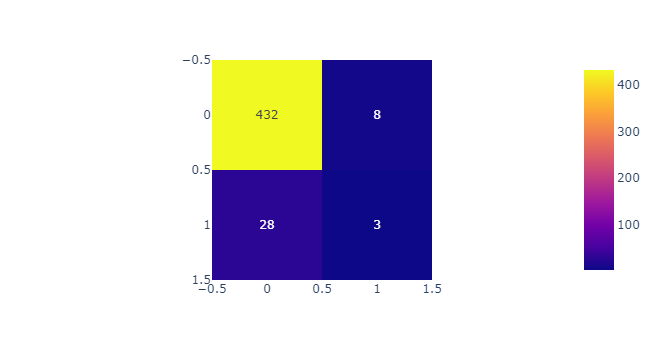

In [ ]:
x = raw_data.drop('Pass/Fail', axis = 1).fillna(0)
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

x_train = pd.DataFrame(RobustScaler().fit_transform(x_train)).reset_index(drop=True)
x_train = x_train.fillna(0)
x_test = pd.DataFrame(RobustScaler().fit_transform(x_test)).fillna(0)
y_train.reset_index(drop=True , inplace =True)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)
model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

#필요 없음


              precision    recall  f1-score   support

           0      0.943     0.973     0.957       440
           1      0.294     0.161     0.208        31

    accuracy                          0.919       471
   macro avg      0.618     0.567     0.583       471
weighted avg      0.900     0.919     0.908       471



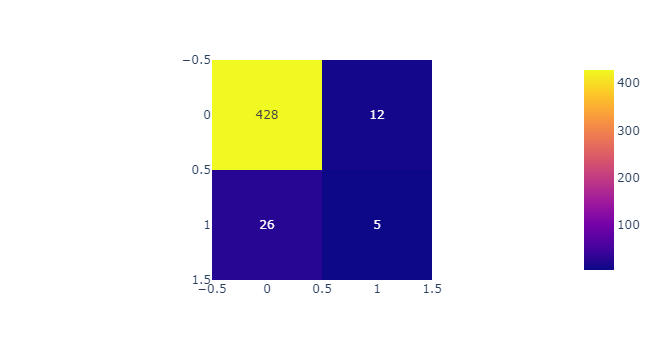

In [ ]:
from sklearn.preprocessing import QuantileTransformer

x = raw_data.drop('Pass/Fail', axis = 1).fillna(0)
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

x_train = pd.DataFrame(QuantileTransformer().fit_transform(x_train)).reset_index(drop=True)
x_train = x_train.fillna(0)
x_test = pd.DataFrame(QuantileTransformer().fit_transform(x_test)).fillna(0)
y_train.reset_index(drop=True , inplace =True)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)
model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

#xxx


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2046, 558)
(2046,)
(471, 558)
(471,)


In [ ]:
from sklearn.preprocessing import RobustScaler

In [118]:
##이거 넣기 모드
x = mode_data
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

sc = StandardScaler()

x_train = pd.DataFrame(sc.fit_transform(x_train))
x_test = pd.DataFrame(sc.transform(x_test))

x_train, y_train = SMOTE().fit_resample(x_train, y_train)


model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# 각 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


# 결과 출력_raw
print("Logistic Regression 결과:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

Logistic Regression 결과:
Accuracy: 0.8821656050955414
Precision: 0.21739130434782608
Recall: 0.20833333333333334
F1 Score: 0.2127659574468085
ROC AUC Score: 0.573132183908046
              precision    recall  f1-score   support

           0      0.935     0.938     0.936       290
           1      0.217     0.208     0.213        24

    accuracy                          0.882       314
   macro avg      0.576     0.573     0.575       314
weighted avg      0.880     0.882     0.881       314



              precision    recall  f1-score   support

           0      0.934     0.931     0.933       290
           1      0.200     0.208     0.204        24

    accuracy                          0.876       314
   macro avg      0.567     0.570     0.568       314
weighted avg      0.878     0.876     0.877       314



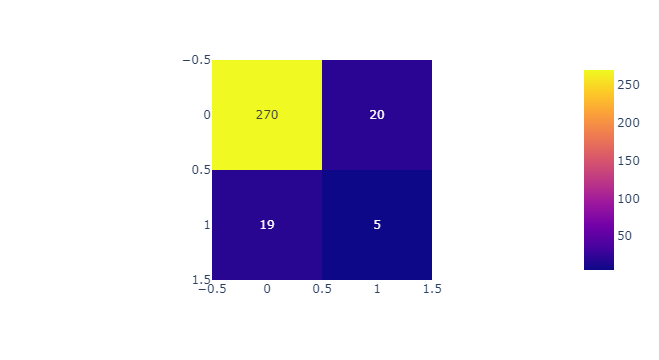

In [ ]:
# 이거 빼
x = mode_data
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

sc = RobustScaler()

x_train = pd.DataFrame(sc.fit_transform(x_train))
x_test = pd.DataFrame(sc.transform(x_test))

x_train, y_train = SMOTE().fit_resample(x_train, y_train)


model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2346, 41)
(2346,)
(314, 41)
(314,)


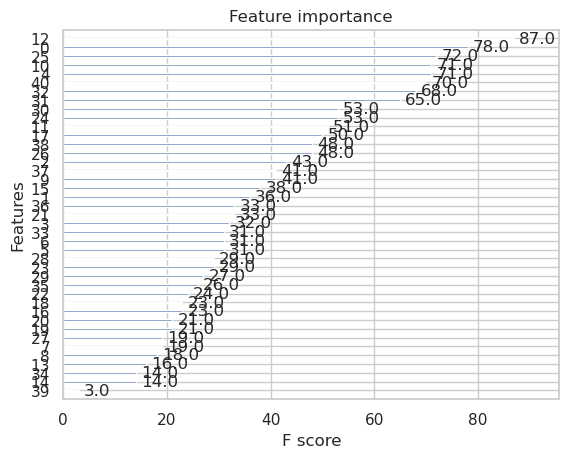

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model)
plt.show()

In [119]:
x = mean_data
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

x_train, y_train = SMOTE().fit_resample(x_train, y_train)

sc = StandardScaler()

x_train = pd.DataFrame(sc.fit_transform(x_train)).reset_index(drop=True)
x_test = pd.DataFrame(sc.transform(x_test))

y_train.reset_index(drop=True , inplace =True)


model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# 각 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


# 결과 출력_raw
print("Logistic Regression 결과:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

Logistic Regression 결과:
Accuracy: 0.8789808917197452
Precision: 0.20833333333333334
Recall: 0.20833333333333334
F1 Score: 0.20833333333333334
ROC AUC Score: 0.5714080459770114
              precision    recall  f1-score   support

           0      0.934     0.934     0.934       290
           1      0.208     0.208     0.208        24

    accuracy                          0.879       314
   macro avg      0.571     0.571     0.571       314
weighted avg      0.879     0.879     0.879       314



In [120]:
x = median_data
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)



x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

x_train, y_train = SMOTE().fit_resample(x_train, y_train)

sc = StandardScaler()

x_train = pd.DataFrame(sc.fit_transform(x_train)).reset_index(drop=True)
x_test = pd.DataFrame(sc.transform(x_test))

y_train.reset_index(drop=True , inplace =True)

model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# 각 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


# 결과 출력_raw
print("Logistic Regression 결과:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

Logistic Regression 결과:
Accuracy: 0.8885350318471338
Precision: 0.2608695652173913
Recall: 0.25
F1 Score: 0.2553191489361702
ROC AUC Score: 0.5956896551724138
              precision    recall  f1-score   support

           0      0.938     0.941     0.940       290
           1      0.261     0.250     0.255        24

    accuracy                          0.889       314
   macro avg      0.600     0.596     0.598       314
weighted avg      0.886     0.889     0.887       314



In [ ]:
pip install "numpy>=1.22.3,<1.23.0" scipy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 18.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


In [ ]:
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'random_state' : [1]}]
###
x = raw_data.drop('Pass/Fail', axis = 1)
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)


x_train = pd.DataFrame(StandardScaler().fit_transform(x_train)).reset_index(drop=True)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test)).reset_index(drop=True)
x_train = x_train.fillna(0)
y_train = y_train.fillna(0)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)


model = XGBClassifier(random_state=1)

# making a grid search model
grid_search = GridSearchCV(estimator = model, param_grid = parameters,  scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train, y_train)

# getting the results
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [ ]:
print(best_accuracy)
print(best_parameters)

0.986322380583219
{'max_depth': 4, 'random_state': 1}


In [ ]:
weights = (y == 1).sum()/(1.0*(y ==0).sum())

model = XGBClassifier(max_depth = 4, scale_pos_weights = weights, n_jobs = -1,random_state=1, cv=3)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

              precision    recall  f1-score   support

           0      0.944     0.950     0.947       440
           1      0.214     0.194     0.203        31

    accuracy                          0.900       471
   macro avg      0.579     0.572     0.575       471
weighted avg      0.896     0.900     0.898       471



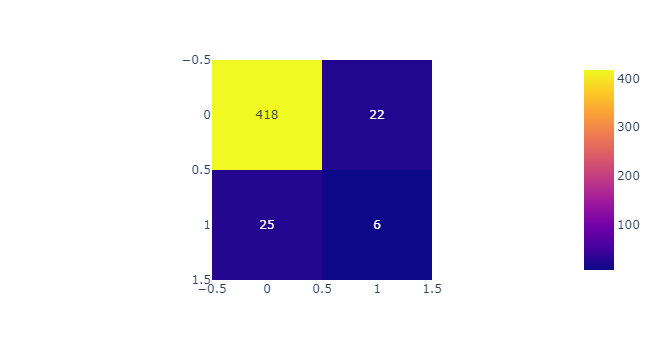

In [ ]:
print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

In [ ]:
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'random_state' : [1]}]
###
x = mode_data
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)


x_train = pd.DataFrame(StandardScaler().fit_transform(x_train)).reset_index(drop=True)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test)).reset_index(drop=True)
x_train = x_train.fillna(0)
y_train = y_train.fillna(0)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)


model = XGBClassifier(random_state=1)

# making a grid search model
grid_search = GridSearchCV(estimator = model, param_grid = parameters,  scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train, y_train)

# getting the results
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print(best_accuracy)
print(best_parameters)

0.9628540759735225
{'max_depth': 6, 'random_state': 1}


              precision    recall  f1-score   support

           0      0.941     0.907     0.924       440
           1      0.128     0.194     0.154        31

    accuracy                          0.860       471
   macro avg      0.534     0.550     0.539       471
weighted avg      0.888     0.860     0.873       471



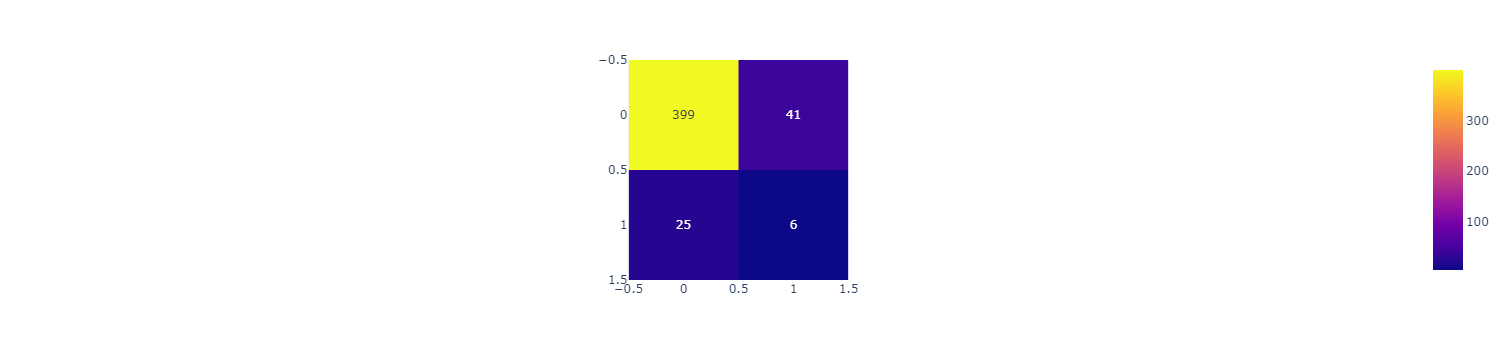

In [ ]:
weights = (y == 1).sum()/(1.0*(y ==0).sum())

model = XGBClassifier(max_depth = 6, scale_pos_weights = weights, n_jobs = -1,random_state=1, cv=3)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

In [ ]:
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'random_state' : [1]}]
###
x = mean_data
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)


x_train = pd.DataFrame(StandardScaler().fit_transform(x_train)).reset_index(drop=True)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test)).reset_index(drop=True)
x_train = x_train.fillna(0)
y_train = y_train.fillna(0)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)


model = XGBClassifier(random_state=1)

# making a grid search model
grid_search = GridSearchCV(estimator = model, param_grid = parameters,  scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train, y_train)

# getting the results
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print(best_accuracy)
print(best_parameters)

0.9667696344445107
{'max_depth': 4, 'random_state': 1}


              precision    recall  f1-score   support

           0      0.950     0.911     0.930       440
           1      0.204     0.323     0.250        31

    accuracy                          0.873       471
   macro avg      0.577     0.617     0.590       471
weighted avg      0.901     0.873     0.886       471



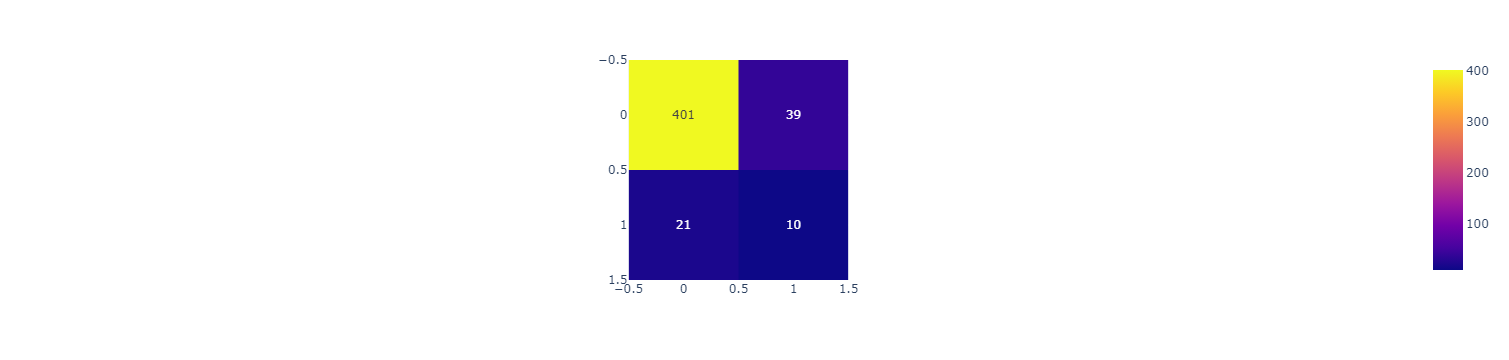

In [ ]:
weights = (y == 1).sum()/(1.0*(y ==0).sum())

model = XGBClassifier(max_depth = 4, scale_pos_weights = weights, n_jobs = -1,random_state=1, cv=3)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

In [ ]:
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'random_state' : [1]}]
###
x = median_data
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)


x_train = pd.DataFrame(StandardScaler().fit_transform(x_train)).reset_index(drop=True)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test)).reset_index(drop=True)
x_train = x_train.fillna(0)
y_train = y_train.fillna(0)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)


model = XGBClassifier(random_state=1)

# making a grid search model
grid_search = GridSearchCV(estimator = model, param_grid = parameters,  scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train, y_train)

# getting the results
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print(best_accuracy)
print(best_parameters)

0.9682282783708033
{'max_depth': 6, 'random_state': 1}


              precision    recall  f1-score   support

           0      0.946     0.918     0.932       440
           1      0.182     0.258     0.213        31

    accuracy                          0.875       471
   macro avg      0.564     0.588     0.573       471
weighted avg      0.896     0.875     0.885       471



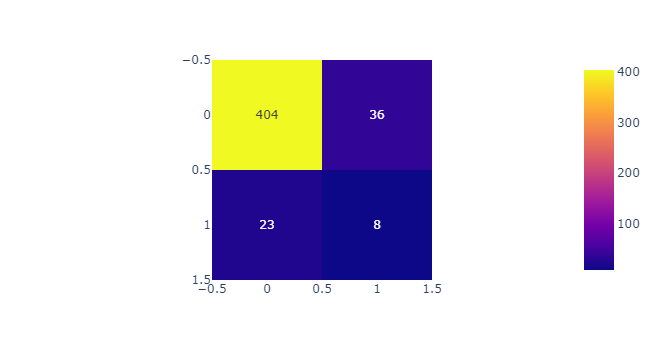

In [ ]:
weights = (y == 1).sum()/(1.0*(y ==0).sum())

model = XGBClassifier(max_depth = 6, scale_pos_weights = weights, n_jobs = -1,random_state=1, cv=3)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)

In [ ]:
# QuantileTransformer
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'random_state' : [1]}]
###
x = mean_data
y = raw_data['Pass/Fail'].apply(lambda x : 0 if x<0 else 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)


x_train = pd.DataFrame(QuantileTransformer().fit_transform(x_train)).reset_index(drop=True)
x_test = pd.DataFrame(QuantileTransformer().fit_transform(x_test)).reset_index(drop=True)
x_train = x_train.fillna(0)
y_train = y_train.fillna(0)
x_train, y_train = SMOTE().fit_resample(x_train, y_train)


model = XGBClassifier(random_state=1)

# making a grid search model
grid_search = GridSearchCV(estimator = model, param_grid = parameters,  scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train, y_train)

# getting the results
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print(best_accuracy)
print(best_parameters)

0.9682366271095473
{'max_depth': 6, 'random_state': 1}


              precision    recall  f1-score   support

           0      0.942     0.920     0.931       440
           1      0.146     0.194     0.167        31

    accuracy                          0.873       471
   macro avg      0.544     0.557     0.549       471
weighted avg      0.890     0.873     0.881       471



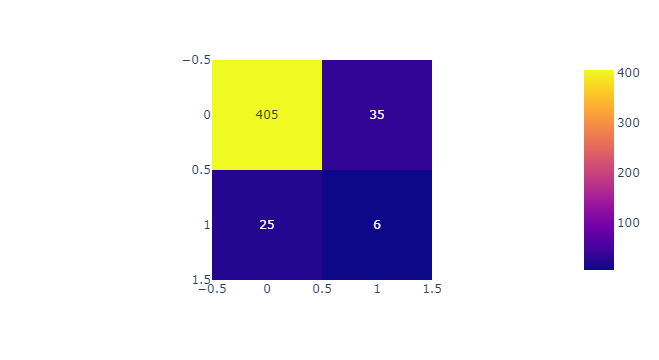

In [ ]:
weights = (y == 1).sum()/(1.0*(y ==0).sum())

model = XGBClassifier(max_depth = 6, scale_pos_weights = weights, n_jobs = -1,random_state=1, cv=3)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred, digits = 3))
px.imshow(confusion_matrix(y_test, y_pred) , text_auto=True)